In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 6.8 MB/s 
     |████████████████████████████████| 965 kB 53.2 MB/s 
     |████████████████████████████████| 235 kB 59.8 MB/s 
     |████████████████████████████████| 581 kB 70.4 MB/s 


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from underthesea import word_tokenize 

from keras import Input, Model
from keras.layers import Embedding, LSTM, Dense
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load data
df = pd.read_csv('Data_ChatBot.csv', usecols=[1,2])
df = df.dropna()
df

,user_a,user_b
0,Thích mẫu người nào,"Dễ thương, tóc dài, da trắng"
1,Có crush ai không,Có 1 bạn cùng lớp
2,Tại sao lại thích bạn dó,Vì đáp ứng những yêu cầu của tao
3,Có hay nói chuyện không,Hay nhắn tin messenger
4,Bạn kia có bắt chuyện trước không,Có đôi khi
...,...,...
5895,Nhà mày bao nhiêu người?,7 8 người gì đó
5896,Có bao nhiêu anh chị em?,3 anh chị em
5897,Mày là em út hay anh cả?,Anh út
5898,Bố mày làm nghề gì?,chủ tịch giả nghèo và cái kết


In [ ]:
# take out question and answer
data_questions = df['user_a'].values
data_answers = df['user_b'].values

In [ ]:
# hàm để xóa các ký tự đặc biệt
def clean_text(sent):
    return re.sub(r'[!“”"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', '', sent)

# hàm để chuyển Word Segmentation cho tiếng Việt
def clean_and_word_segmentation(sent):
    return word_tokenize(clean_text(sent.lower()), format='text')

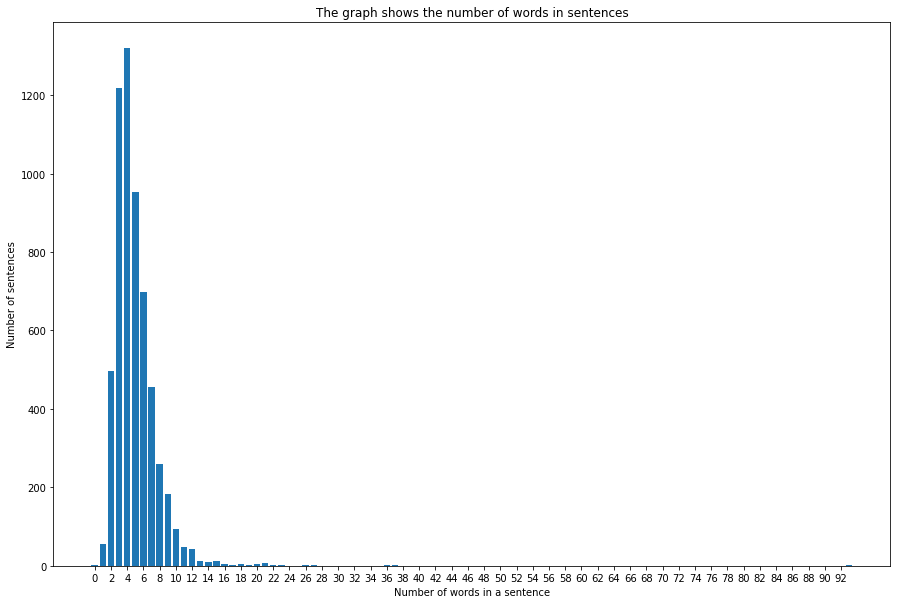

In [ ]:
# vẽ biểu đồ thể hiện trực quan số lượng từ trong các questions
count_words_ques = [len(clean_text(ques).split()) for ques in data_questions]
counter_words_ques = Counter(count_words_ques)

list_count_word = []
list_count_sent = []
for i in counter_words_ques.items():
    #print(i)
    list_count_word.append(i[0])
    list_count_sent.append(i[1])
    
# ========== draw ========== #
plt.figure(figsize=(15,10))
plt.bar(list_count_word,list_count_sent)
plt.title('The graph shows the number of words in sentences')
plt.xlabel('Number of words in a sentence')
plt.ylabel('Number of sentences')
plt.xticks(range(min(list_count_word), max(list_count_word),2))
plt.show()

In [ ]:
len(count_words_ques), len(data_questions)

(5899, 5899)

In [ ]:
# loại bỏ những câu có số lượng từ > 15 từ
sorted_ques = []
sorted_ans = []
for i,count in enumerate(count_words_ques):
    if count <= 15:
        sorted_ques.append(data_questions[i])
        sorted_ans.append(data_answers[i])
        
print('len sorted_ques:', len(sorted_ques))
print('len sorted_ans:', len(sorted_ans))
sorted_ques[:2], sorted_ans[:2]

len sorted_ques: 5863
len sorted_ans: 5863


(['Thích mẫu người nào', 'Có crush ai không'],
 ['Dễ thương, tóc dài, da trắng', 'Có 1 bạn cùng lớp'])

In [ ]:
# làm sạch và Word Segmentation cho sorted_ques và sorted_ans
questions = [clean_and_word_segmentation(ques) for ques in sorted_ques]
answers = ['<START> '+ clean_and_word_segmentation(answ) + ' <END>' for answ in sorted_ans]

questions[:2], answers[:2]

(['thích mẫu người nào', 'có crush ai không'],
 ['<START> dễ_thương tóc dài da trắng <END>',
  '<START> có 1 bạn cùng lớp <END>'])

In [ ]:
# tokenize cho questions và answers
tokenizer = Tokenizer(filters='', lower=False)  # filters='' do dữ liệu đã được làm sạch và giữ lại word segmention
tokenizer.fit_on_texts(questions + answers)

# for word_index in tokenizer.word_index.items():
#     print(word_index)

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size : {VOCAB_SIZE}')

Vocabulary size : 3552


In [ ]:
# encoder
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = 15
encoder_inp = pad_sequences(tokenized_questions,maxlen=maxlen_questions,padding='post')

print(encoder_inp.shape)
print(questions[0])
print(tokenized_questions[0])
print(encoder_inp[0])

(5863, 15)
thích mẫu người nào
[11, 271, 26, 13]
[ 11 271  26  13   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
# decoder
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = np.max([len(x) for x in tokenized_answers])
decoder_inp = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

print(decoder_inp.shape)
print(answers[0])
print(tokenized_answers[0])
print(decoder_inp[0])

(5863, 43)
<START> dễ_thương tóc dài da trắng <END>
[1, 318, 1263, 369, 2447, 471, 2]
[   1  318 1263  369 2447  471    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [ ]:
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
    
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_final_output = to_categorical(padded_answers, VOCAB_SIZE)

print(decoder_final_output.shape)
print(tokenized_answers[0])
print(padded_answers[0])
print(decoder_final_output[0])

(5863, 43, 3552)
[318, 1263, 369, 2447, 471, 2]
[ 318 1263  369 2447  471    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
_, state_h, state_c = LSTM(200, return_state=True)(enc_embedding)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(200, return_state=True, return_sequences=True)

dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
dec_dense = Dense(VOCAB_SIZE, activation='softmax')
output = dec_dense(dec_outputs)

In [ ]:
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    710400      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    710400      ['input_2[0][0]']                
                                                                                              

In [ ]:
model.fit([encoder_inp, decoder_inp],
           decoder_final_output,
           batch_size=50,
           epochs=150)

#
# batch_size là 150
# epochs là 300
model.save('sequence2sequence_lstm.h5')

Epoch 1/150
118/118 [==============================] - 79s 562ms/step - loss: 0.5372
Epoch 2/150
118/118 [==============================] - 66s 563ms/step - loss: 0.4625
Epoch 3/150
118/118 [==============================] - 66s 562ms/step - loss: 0.4477
Epoch 4/150
118/118 [==============================] - 66s 560ms/step - loss: 0.4346
Epoch 5/150
118/118 [==============================] - 66s 557ms/step - loss: 0.4208
Epoch 6/150
118/118 [==============================] - 63s 532ms/step - loss: 0.4083
Epoch 7/150
118/118 [==============================] - 63s 530ms/step - loss: 0.3975
Epoch 8/150
118/118 [==============================] - 63s 532ms/step - loss: 0.3872
Epoch 9/150
118/118 [==============================] - 62s 528ms/step - loss: 0.3777
Epoch 10/150
118/118 [==============================] - 64s 539ms/step - loss: 0.3675
Epoch 11/150
118/118 [==============================] - 63s 530ms/step - loss: 0.3575
Epoch 12/150
118/118 [==============================] - 60s 512

In [ ]:
def make_inference_models():
    dec_state_input_h = Input(shape=(200,))
    dec_state_input_c = Input(shape=(200,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                            initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs = [dec_outputs] + dec_states)
    print('Inference decoder:')
    dec_model.summary()
    print('Inference encoder:')
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    enc_model.summary()
    return enc_model, dec_model

def str_to_tokens(sentence):
    #words = sentence.lower().split()
    words = clean_and_word_segmentation(sentence).split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word)
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list], maxlen=maxlen_questions,padding='post')

enc_model, dec_model = make_inference_models()

Inference decoder:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    710400      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                         

In [ ]:
def chatbot():
    print('Bot: Xin chào!')
    
    while True:
        input_question = input('User:')

        if input_question == 'bye' or input_question == 'tạm biệt':
            print('Bot: thế mà bạn bảo bạn yêu tôi, bạn thích tôi, mà bạn bỏ rơi tôi, huhu!')
            break
        states_values = enc_model.predict(str_to_tokens(input_question))
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = tokenizer.word_index['<START>']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition:
            dec_outputs, h, c = dec_model.predict([empty_target_seq]+states_values)
            sampled_word_index = np.argmax(dec_outputs[0,-1, :])
            sampled_word = None
            for word, index in tokenizer.word_index.items():
                if sampled_word_index == index:
                    if word != '<END>':
                        decoded_translation += f'{word} '
                    sampled_word = word

            if sampled_word == '<END>' or len(decoded_translation.split()) > maxlen_answers:
                stop_condition = True
            empty_target_seq = np.zeros((1,1))
            empty_target_seq[0,0] = sampled_word_index
            states_values = [h,c]

        print('Bot:', decoded_translation)

In [ ]:
# chat with bot
chatbot()

Bot: Xin chào!
User:chào cái gì
Bot: thích ăn 
User:bye
Bot: thế mà bạn bảo bạn yêu tôi, bạn thích tôi, mà bạn bỏ rơi tôi, huhu!
